In [2]:
import polars as pl
import geopandas as gpd
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.cluster as skc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
#from prophet import Prophet
#import pymc3 as pm
import pandas as pd
from scipy.integrate import odeint
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm

from scipy.cluster.hierarchy import dendrogram, linkage



In [ ]:
test = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')
test

In [3]:
monthly_cases = pl.read_parquet('../data/cases/agged/dengue_per_month.parquet')
monthly_params = pl.read_parquet('../data/gee_exports/all_parameters_2001-01-01_2021-01-01_months.parquet')
weekly_cases = pl.read_parquet('../data/cases/agged/dengue_per_week.parquet')
daily_cases = pl.read_parquet('../data/cases/agged/dengue_per_day.parquet')

In [33]:
monthly_cases.columns

['ID_MUNICIP',
 'DT_NOTIFIC',
 'count',
 'x_centroid',
 'y_centroid',
 'NM_MUN',
 'pop',
 'year',
 'cases_per_100k']

In [265]:
#TODO: something going wrong with the join on this one
#monthly_params = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')

In [4]:
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp').astype({'CD_MUN': 'string'})

In [5]:
munis['CD_MUN'] = munis['CD_MUN'].str.slice(stop=-1).astype(int)

In [30]:
munis[munis['CD_MUN']==251315] 

CD_MUN         NM_MUN SIGLA  AREA_KM2  \
1408  251315  Santa Cecília    PB   217.577   

                                               geometry  
1408  POLYGON ((-35.94848 -7.65620, -35.94400 -7.663...

In [4]:
monthly_params = monthly_params.with_columns((pl.col('start_date').str.to_date('%Y-%m-%d'),pl.col('end_date').str.to_date('%Y-%m-%d')))

In [5]:
#monthly_params.sort(['muni_id', 'end_date'])
monthly_cases = monthly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
})

In [3]:
weekly_cases = weekly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
}).with_columns(pl.col('start_date').alias('month').dt.month())

In [ ]:
daily_cases = daily_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
    'DT_NOTIFIC': 'start_date',
    'ID_MUNICIP': 'muni_id'
})

In [6]:
all_data = monthly_cases.join(monthly_params, how='left', on=['muni_id', 'start_date']).with_columns(pl.col('end_date').alias('month').dt.month())


In [9]:
#data = monthly_cases.group_by(pl.col('start_date')).agg((pl.col('count').sum(), pl.col('pop').sum())).to_pandas()

data = all_data.select(['muni_id', 'cases_per_100k', 'start_date', ]).to_pandas()

In [10]:
pivot_df = data.pivot(index = 'start_date', columns='muni_id', values='cases_per_100k')

In [53]:
np.corrcoef(all_data.select(['muni_id', 'cases_per_100k', 'start_date']).pivot(index = 'muni_id', columns='start_date', values='cases_per_100k'))[0]

array([1.        , 0.99994152, 0.999944  , ..., 0.99994593, 0.99996723,
       0.99963075])

In [36]:
corr_matrix = pivot_df.corr()

In [699]:
np.nanmean(np.triu(corr_matrix.to_numpy(), k=1))

0.057370696997456595

In [35]:
#412050 is least helped by adding neighbors
corr_matrix.loc[352115].sort_values().nlargest(10)

muni_id
352115    1.000000
352810    0.794703
314050    0.775560
351550    0.765224
313630    0.753918
353280    0.751342
350780    0.743044
521056    0.739011
355560    0.737278
350460    0.735800
Name: 352115, dtype: float64

In [37]:
corr_abs = corr_matrix #.abs()

# Create an empty matrix to store the results
top_correlated_matrix = pd.DataFrame(index=corr_abs.index, columns=range(1, 10))

# Loop through each row in the correlation matrix
for idx, row in corr_abs.iterrows():
    # Sort the correlations in descending order and get the top 20
    top_correlated = row.sort_values(ascending=False)[1:10]
    
    # Assign the top correlated items to the respective row in the result matrix
    top_correlated_matrix.loc[idx] = top_correlated.index

# Print the top correlated matrix
#print(top_correlated_matrix)
top_correlated_matrix.loc[[431870,]]

1       2       3       4       5       6       7       8  \
muni_id                                                                   
431870   330180  420430  330290  430920  430510  431490  250580  330250   

              9  
muni_id          
431870   330390

In [38]:
proj_mun = munis.to_crs('EPSG:29101')

In [39]:
coordinates_df = pd.DataFrame(index=proj_mun['CD_MUN'])
coordinates_df['x_coordinate'] = proj_mun.geometry.centroid.x.to_numpy()
coordinates_df['y_coordinate'] = proj_mun.geometry.centroid.y.to_numpy()

In [40]:
combined_df = pd.merge(top_correlated_matrix, coordinates_df, left_index=True, right_index=True)
combined_df

1       2       3       4       5       6       7       8  \
110001  510025  313090  510410  292760  330513  422000  311660  251550   
110002  291610  320390  110155  290395  291390  291100  230490  110004   
110003  521860  350390  510060  354025  261100  350055  330400  261530   
110004  110018  120025  110002  510180  110015  110028  110020  110011   
110005  330080  330540  316950  292780  110150  316340  315890  330530   
...        ...     ...     ...     ...     ...     ...     ...     ...   
522200  522060  520590  354425  530010  353260  522185  316220  411605   
522205  260520  520450  314310  520390  520890  352390  522150  311150   
522220  520017  521920  520530  310855  520090  411500  240040  314350   
522230  520860  350635  521090  521523  520810  350760  521760  520480   
530010  522060  520620  353260  411510  354425  353540  351535  352960   

             9  x_coordinate  y_coordinate  
110001  330310  4.100689e+06  8.606969e+06  
110002  150020  4.017938e+06  8.886231e+06  
110003  521290  4.281208e+06  8.500077e+06  
110004  150195  4.200466e+06  8.740233e+06  
110005  410430  4.213087e+06  8.528411e+06  
...        ...           ...           ...  
522200  521760  5.592538e+06  8.132136e+06  
522205  521310  5.437794e+06  8.034842e+06  
522220  520250  5.746080e+06  8.330132e+06  
522230  520500  5.557108e+06  8.304577e+06  
530010  410480  5.664633e+06  8.244798e+06  

[5570 rows x 11 columns]

In [41]:
from shapely import Point, LineString
# Define a function to compute the distance between coordinates
def compute_distance(row, original_x, original_y):
    return ((row['x_coordinate'] - original_x) ** 2 + (row['y_coordinate'] - original_y) ** 2) ** 0.5


ids = []
geos = []

for i in range(0, len(combined_df)):
    matches = coordinates_df.loc[combined_df.iloc[i][0:9]]
    x, y = combined_df.iloc[i]['x_coordinate'], combined_df.iloc[i]['y_coordinate']
    matches['distance'] = ((matches['x_coordinate']- x) ** 2 + (matches['y_coordinate'] - y) ** 2) ** 0.5
    matches = matches.sort_values('distance')
    geo = LineString([Point(x,y)]+[Point(x_,y_) for x_, y_ in zip(matches['x_coordinate'], matches['y_coordinate'])])
    geos.append(geo)
    ids.append(combined_df.index[i])

combined_df.iloc[i]

1                       522060
2                       520620
3                       353260
4                       411510
5                       354425
6                       353540
7                       351535
8                       352960
9                       410480
x_coordinate    5664632.559217
y_coordinate    8244797.617601
Name: 530010, dtype: object

In [42]:
gdf = gpd.GeoDataFrame(index=ids, data=ids, geometry=geos, crs='EPSG:29101').to_crs('EPSG:4326')
gdf_ = gpd.GeoDataFrame(index=ids, data=ids, geometry=geos, crs='EPSG:29101')
lengths = []
for row in gdf_.iterfeatures():

    first = row['geometry']['coordinates'][0]
    last = row['geometry']['coordinates'][-1]

    distance = ((first[0] - last[0]) ** 2 + (first[1]-last[1]) ** 2) ** 0.5
    lengths.append(distance/1000)
lengths = np.array(lengths)
print(lengths.mean())
print(lengths.min())
print(lengths.max())

1742.8101901719958
61.769337951448435
3976.4129635520894


In [31]:
import leafmap.foliumap as leafmap
m = leafmap.Map(center=(40, -100), zoom=3)
#TODO: SEARCH FOR OVERLAPPING LINE SEGMENTS
id = 251315                      #   412050
m.add_gdf(gdf.iloc[np.random.choice(list(range(0,5500)), size=10)])



# m.add_gdf(gdf.loc[[id,]])
# first = gdf.loc[[id,]].geometry.item().coords[0]
# m.add_gdf(gpd.GeoDataFrame(data=[id], geometry=[Point(first)], crs='EPSG:4326'))

m

In [662]:
a = gdf.loc[[412050,]].geometry.item().coords[0]
print(a)

(-51.07409430404529, -22.862177160842837)


Each row:
Target: This months cases per 100k
Features: 
    This months environmental variables
    Previous 24 months environmental variables
    Previous 24 months case history
    Previous 12 months case history for 10 most related munis

In [61]:


X


array([[  0.        ,  30.47479734,  67.04455415, ..., 299.79904747,
        299.88002586,   2.        ],
       [ 30.47479734,  67.04455415,   0.        , ..., 299.88002586,
        298.62291781,   3.        ],
       [ 67.04455415,   0.        ,   0.        , ..., 298.62291781,
        296.92055575,   4.        ],
       ...,
       [ 93.6652699 ,  64.08676362, 162.68178457, ..., 299.16601785,
        299.70118713,  11.        ],
       [ 64.08676362, 162.68178457, 239.21109158, ..., 299.70118713,
        299.44165103,  12.        ],
       [162.68178457, 239.21109158, 449.1310291 , ..., 299.44165103,
        299.29736837,   1.        ]])

In [521]:
X[:,-1]

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,
        3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,
        5.,  6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,
        6.,  7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,
        7.,  8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
        9., 10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
       10., 11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        1.])

In [115]:
def assemble_data(muni_id, start_date, end_date, env_lookback=1, local_case_lookback=2, neighbor_case_lookback=1, use_neighbors=True):
    targets = []
    features = []
    muni_ids = []
    dates = []

    start_date = datetime.fromisoformat(start_date)
    end_date = datetime.fromisoformat(end_date)
    i=muni_id

    for j in all_data.select('start_date').filter((pl.col('start_date')>=start_date) & (pl.col('start_date')<end_date)).unique().to_series():
        neighbors = top_correlated_matrix.loc[i]

        this_data = all_data.filter(pl.col('muni_id')==i)

        target = this_data.filter(pl.col('start_date') == j).select('cases_per_100k').item()
        target_month = this_data.filter(pl.col('start_date') == j).select('month').to_numpy()

        env_list = [
                    #'EVI', 
                    'total_precipitation_sum', 
                    'temperature_2m', 
                    #'month'
                    ]

        env_table = this_data.select(['start_date'] + env_list)

        env_vars = env_table.filter((pl.col('start_date')<=j) & (pl.col('start_date')>j-relativedelta(years=env_lookback))).select(env_list).unstack(step=1).to_numpy()
        local_cases = this_data.filter((pl.col('start_date')<j) & (pl.col('start_date')>=j-relativedelta(years=local_case_lookback))).select('cases_per_100k').unstack(step=1).to_numpy()
        local_means =  this_data.filter((pl.col('start_date')<j) & (pl.col('start_date')>=j-relativedelta(years=1))).select(pl.col('cases_per_100k').ewm_mean(com=1)).drop_nulls().unstack(step=1).to_numpy()
        env_means = env_table.filter((pl.col('start_date')<=j) & (pl.col('start_date')>j-relativedelta(years=env_lookback))).select(pl.col(env_list).rolling_mean(3)).drop_nulls().unstack(step=1).to_numpy()
        
        to_stack = [
            local_cases,
            local_means,
            env_vars,
            #env_means,
            target_month
        ]
        if use_neighbors:
            neighbors_cases = (all_data
                               .filter((pl.col('muni_id').is_in(neighbors)) & (pl.col('start_date')<j) & (pl.col('start_date')>=j-relativedelta(years=neighbor_case_lookback)))
                               .select(pl.col('cases_per_100k')).drop_nulls()
                               .unstack(step=1)
                               .to_numpy()
            )
            to_stack = [neighbors_cases] + to_stack
        feature = np.squeeze(
                np.hstack(
                    to_stack
            )
        )

        targets.append(target)
        features.append(feature)
        muni_ids.append(i)
        dates.append(j)

    y = np.array(targets)
    X = np.vstack(features)

    return {
        'X': X,
        'y': y,
        'muni_id': i,
        'dates': dates
    }


In [64]:
rng = np.random.default_rng(seed=42)
test_munis = rng.choice(all_data.select('muni_id').unique().sort('muni_id').to_series().to_numpy(), size=1000)
test_munis = [
315670,	
312380,	313370,	412050,
]

In [65]:
def train_and_test_reg(train, test):
    reg = HistGradientBoostingRegressor(
    random_state=42,
    categorical_features = [train['X'].shape[1]-1], 
    loss='poisson', 
    max_iter=5000, 
    max_leaf_nodes=None, 
    min_samples_leaf=10,
    l2_regularization=2.0, 
    max_bins=255,
    early_stopping=False)
    reg.fit(train['X'], train['y'])
    z =reg.predict(test['X'])

    return {
        'reg': reg,
        'predictions': z,
        'test_data': test['y'],
        'score': reg.score(test['X'], test['y']),
        'rmse': np.sqrt(((z - test['y']) ** 2).mean())
    }

In [116]:
el = 1
lc = 2
nc = 1
results_dict = {}
for muni in tqdm(test_munis):
    train_data = assemble_data(muni,'2010-01-01', '2018-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=True)
    if train_data['y'].sum() == 0:
        continue
    test_data = assemble_data(muni,'2018-01-01', '2020-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=True)
    neighbor_results = train_and_test_reg(train_data, test_data)

    train_data = assemble_data(muni,'2010-01-01', '2018-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=False)
    if train_data['y'].sum() == 0:
        continue
    test_data = assemble_data(muni,'2018-01-01', '2020-01-01', env_lookback=el, local_case_lookback=lc, neighbor_case_lookback=nc, use_neighbors=False)
    no_neighbor_results = train_and_test_reg(train_data, test_data)

    results_dict[muni] = {
        'neighbors': neighbor_results,
        'no_neighbors': no_neighbor_results,
        'neighbor_rmse': neighbor_results['rmse'],
        'no_neighbor_rmse': no_neighbor_results['rmse']
    }
    


  0%|          | 0/4 [00:00<?, ?it/s]

In [117]:
ids = []
neighbors_rmse = []
no_neighbors_rmse = []

for k, v in results_dict.items():
    ids.append(k)
    neighbors_rmse.append(v['neighbor_rmse'])
    no_neighbors_rmse.append(v['no_neighbor_rmse'])

results_df = pd.DataFrame(index=ids, data={'neighbors_rmse': neighbors_rmse, 'no_neighbors_rmse': no_neighbors_rmse, 'muni_id': ids})
results_df['neighbor_improvement'] = results_df['no_neighbors_rmse'] - results_df['neighbors_rmse']

results_df.sort_values('neighbor_improvement', ascending=False)

neighbors_rmse  no_neighbors_rmse  muni_id  neighbor_improvement
313370      734.110083         706.067714   313370            -28.042370
412050     1225.216854        1193.784755   412050            -31.432099
315670      282.392899         140.776399   315670           -141.616500
312380      231.062707          82.276475   312380           -148.786232

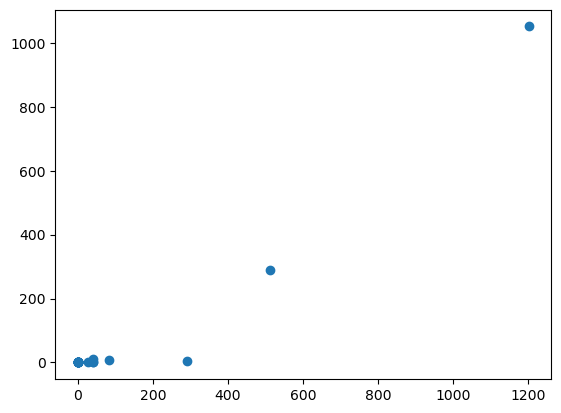

In [118]:
plt.scatter(results_dict[312380]['no_neighbors']['test_data'],results_dict[312380]['no_neighbors']['predictions'])

In [648]:
(results_df['neighbor_improvement']>0).sum()

450

In [649]:
results_gdf = munis.merge(results_df, left_on='CD_MUN', right_on='muni_id')

<Axes: >

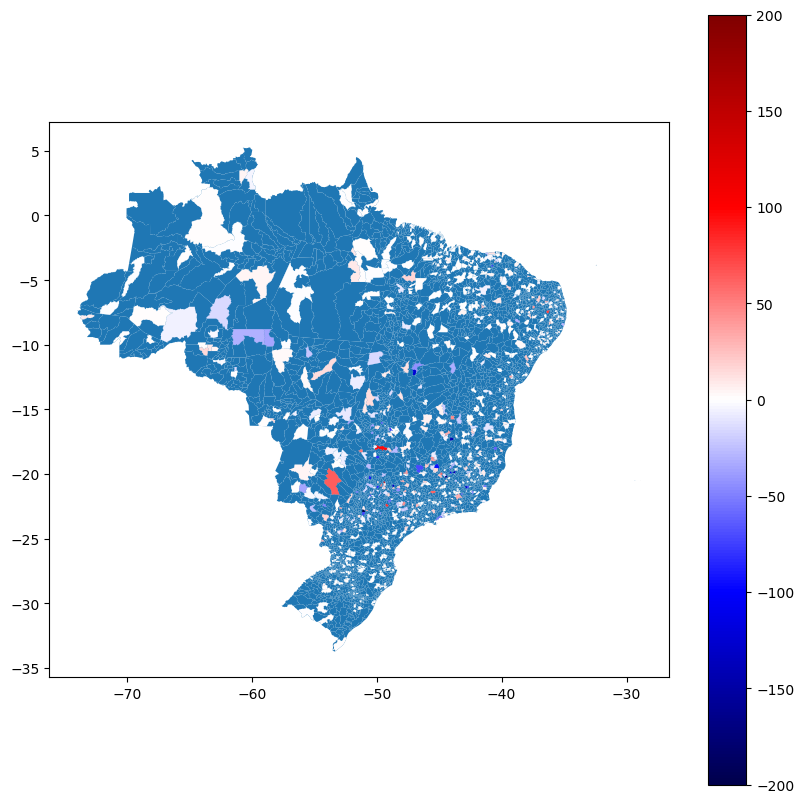

In [700]:
ax= munis.plot(figsize=(10,10))
results_gdf.plot(ax=ax, column=results_gdf['neighbor_improvement'], cmap='seismic', legend=True, vmin=-200, vmax=200)
#Can check relationship with population

In [709]:
import leafmap.foliumap as leafmap
import leafmap.colormaps as cm
m = leafmap.Map(center=(40, -100), zoom=3)
#TODO: SEARCH FOR OVERLAPPING LINE SEGMENTS
id = 412050
#m.add_gdf(gdf.iloc[np.random.choice(list(range(0,5500)), size=10)])
#m.add_gdf(gdf.loc[[431870,]])
m.add_data(results_gdf, column='neighbor_improvement', cmap='seismic', scheme='EqualInterval')
m

: 

In [ ]:
test_muni = all_data.filter(pl.col('muni_id') == 530010)

In [7]:
cluster_features = ['cases_per_100k', 
                     #'temperature_2m', 
                     #'total_precipitation_min', 
                    # 'EVI'
                    ]
case_matrix = np.vstack(
                all_data
                #weekly_cases
               .select(pl.col(['end_date', 'muni_id',  'month'] + cluster_features))
               .filter(
                    (pl.col('end_date') >= datetime(2010,1,1)) &
                    (pl.col('end_date') < datetime(2019,1,1)) &
                    (pl.col('month').is_in([11, 12, 1, 2, 3, 4, 5]))
                    )
               .sort('end_date')
               .group_by('muni_id', maintain_order=True)
               .agg([pl.col(f) for f in cluster_features])
               .sort('muni_id')
               .select(pl.concat_list(cluster_features))
               .to_series()
               )
case_matrix.shape

(5570, 63)

In [8]:
X = case_matrix
Z = linkage(X, 'ward')
#fig = plt.figure(figsize=(25, 10))
#dn = dendrogram(Z)

In [8]:
def create_tree(centers):
    clusters = {}
    to_merge = linkage(centers, method='ward')
    for i, merge in enumerate(to_merge):
        if merge[0] <= len(to_merge):
            # if it is an original point read it from the centers array
            a = centers[int(merge[0]) - 1]
        else:
            # other wise read the cluster that has been created
            a = clusters[int(merge[0])]

        if merge[1] <= len(to_merge):
            b = centers[int(merge[1]) - 1]
        else:
            b = clusters[int(merge[1])]
        # the clusters are 1-indexed by scipy
        clusters[1 + i + len(to_merge)] = {
            'children' : [a, b]
        }
        # ^ you could optionally store other info here (e.g distances)
    return clusters

tree = create_tree(X)

In [9]:

np.set_printoptions(suppress=True)

In [19]:
Z[:,0].max()

11133.0

In [16]:
c_list = [[[] for i in range(0, int(Z[:,1].max()))]]
c_dict = dict()
for i, row in enumerate(Z):

    
    pass

In [9]:
X = case_matrix
nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [10]:
clusters = skc.AgglomerativeClustering(n_clusters=10).fit_predict(X)

In [11]:
muni_ids = all_data.select(pl.col('muni_id')).unique().sort('muni_id').to_series()

In [12]:
muni_cluster_mapper = {m:c for m, c in zip(muni_ids, clusters)}

In [13]:
clustered_data = all_data.with_columns(pl.col('muni_id').map_dict(muni_cluster_mapper).alias('cluster'))

In [14]:
clustered_data
clustered_data.select(pl.first('count')).item()

4

In [15]:
split_clusters = [clustered_data.filter(pl.col('cluster') == c).group_by(['start_date']).agg(pl.col('count').sum(), pl.col('cluster').first()) for c in np.unique(clusters)]

In [ ]:
split_clusters[0]

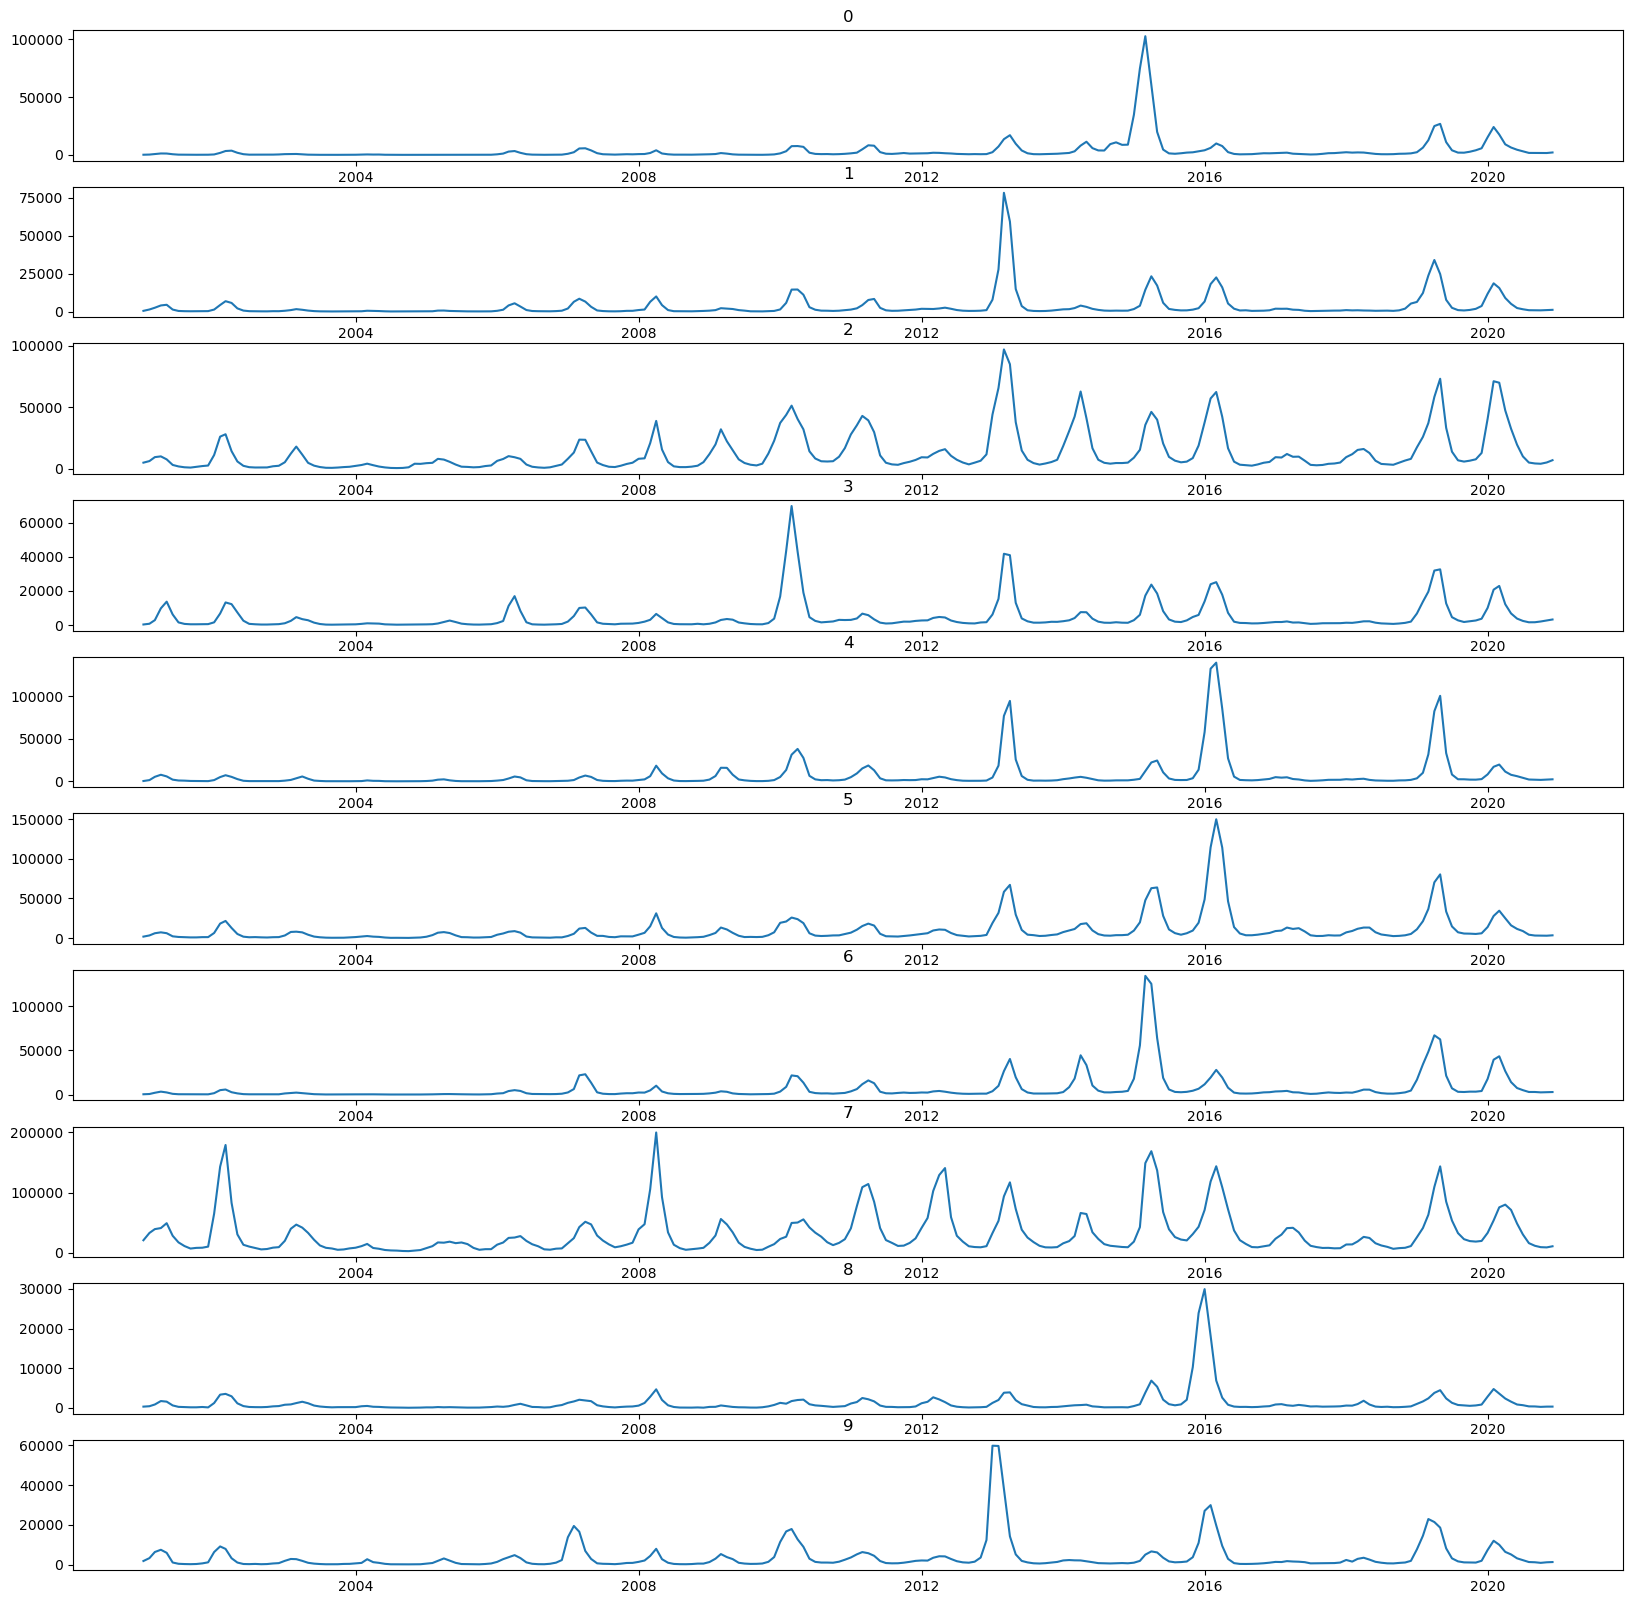

In [16]:
fig, ax = plt.subplots(nrows=10, figsize=(20,20))
for i, c in enumerate(split_clusters):
    ax[i].plot(c['start_date'], c['count'])
    ax[i].set_title(c.select(pl.first('cluster')).item())

In [ ]:
data = {'date': [1, 2, 3, 4, 5, 6, 7], 'infected': [1, 3, 8, 15, 30, 50, 70]}
df = pd.DataFrame(data)
train_sir_model(df)

In [ ]:
index_muni_mapper = {m:i for m, i in enumerate(all_data.select('muni_id').unique().sort('muni_id').to_series())}

In [ ]:
connections = pl.DataFrame({
    'muni_id': all_data.select('muni_id').unique().sort('muni_id').to_series(),
    'indices': indices,
    'distances': distances
}).with_columns(pl.col('indices').list.eval(pl.element().map_dict(index_muni_mapper)).alias('muni_neighbors'))

In [ ]:
def select_muni_and_neighbors(muni_id, data_df, connections_df) -> pl.DataFrame: 
    return (
        data_df
        .filter(
            pl.col('muni_id')
            .is_in(connections_df
                   .filter(pl.col('muni_id') == muni_id)
                   .select('muni_neighbors')
                   .to_series()
                   .item()
                )
            )
    )

    

In [ ]:
def get_solo_training_target(df, muni_id, month_lag, predict_lag):
    lagged_df = (df
        .filter(pl.col('muni_id') == muni_id)
        .sort('end_date')
        .with_columns(
            case_lag = pl.col('cases_per_100k')
            .rolling(index_column='end_date', period=f'{month_lag}mo')
            .list
            .head(month_lag - predict_lag)
            )
        .filter(pl.col('case_lag').list.len() == month_lag-predict_lag)
        .select(['cases_per_100k', 'case_lag'])
    )
    target = lagged_df.select('cases_per_100k').to_series().to_numpy()
    train = np.vstack(lagged_df.select('case_lag').to_series())

    return train, target

In [ ]:
neighbor_list = (connections.filter(pl.col('muni_id') == 230835)
                   .select('muni_neighbors')
                   .to_series()
                   .item()
)
train_list = []
first_train, target = get_solo_training_target(all_data, neighbor_list[0], 24, 1)
train_list.append(first_train)
for neighbor in neighbor_list[1:]:
    to_add, _ = get_solo_training_target(all_data, neighbor, 23, 0)
    train_list.append(to_add)
X = np.concatenate(train_list, axis=1)
y = target

In [ ]:
X.shape

In [ ]:
#X, y = get_solo_training_target(all_data, 230835, 24, 1)
